### Setup Usual Packages
These are the usual python packages we use for retrieving, analyzing, manipulating, and visualizing data in the notebook. For retrieving data, we will use larcv, specifically IOManager and ProcessDriver. For manipulating and analyzing data we use a combination of custom ROOT packages -- geo2d, larocv -- and some external packages like numpy (np) and opencv (cv2)

In [1]:
import os, sys
import ROOT
from ROOT import geo2d
from larcv import larcv
import cv2
pygeo = geo2d.PyDraw()
from ROOT import larocv
from ROOT import cv
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
matplotlib.rcParams['font.size']=20
matplotlib.rcParams['font.family']='serif'
%matplotlib inline
import numpy as np

### Prepare ProcessDriver to execute the reconstruction chain
We will get a process driver instance, and pass it our configuration file. Since this framework is factory based, ProcessDriver is going to chain together a set of LArCV modules together to run sequentially. We will pass a single input file to run the reconstruction on.

In [2]:
proc = larcv.ProcessDriver('ProcessDriver')
CFG="../cfg/prod_fullchain_ssnet_combined_test.cfg"

print "Loading config... ",CFG
proc.configure(CFG)
flist=ROOT.std.vector('std::string')()
#curl -O https://www.nevis.columbia.edu/~vgenty/public/one_event_test.root
flist.push_back("/Users/vgenty/Desktop/intrinsic_nue/out_pyroi/larcv_fcn_out.root")
proc.override_input_file(flist)
proc.override_output_file("/tmp/cacca0.root")
proc.override_ana_file("/tmp/cacca1.root")

proc.initialize()

Loading config...  ../cfg/prod_fullchain_ssnet_combined_test.cfg


### ImageManager Instance
We will access algorithm data via the LArbysImage Manager instance, for which LArbysImage has a pointer to. Here we get a pointer to the LArbysImage instance (the guy that is executing our algorithms on the cv::Mat images). Its name is larbysimg. The LArbysImage class has a function called Manager() which allows you to return the ImageManager which holds the cv::Mat images for adc/track/shower & has an access to per-algorithm data

In [3]:
reco_id    = proc.process_id("LArbysImage")# This returns the algorithm ID of the module
print "process of 'LArbysImage' is, ", reco_id
larbysimg  = proc.process_ptr(reco_id)# This returns the pointer of the LArCV module
mgr = larbysimg.Manager()# LArbysImage Manager Instance which has a data manager to data fo LArOpenCV modules
dm  = mgr.DataManager()# DataManager to access LArOpenCV data
idx = 0
for module in dm.Names():# Name function to show all LArOpenCV modules
    print idx, module
    idx+=1

process of 'LArbysImage' is,  9
0 adc_superclustermaker
1 trackvertexseeds
2 trackvertexestimate
3 trackvertexscan
4 showerplaneseeds
5 showervertexscan
6 vertexparticleclustermaker
7 combinedvertexanalysis


### Event selection
Select the event you want to reconstruct, there is only 1 event in this example file, so lets use the first one. 

In [4]:
event = 52
proc.batch_process(event,1)

### SSNet Output
Here we display for the given ROI the SSNet label image (yellow is track, cyan is shower). How are we doing this?
We are asking the ImageManager for the adc (imageid=0), track (imageid=1), and shower (imageid=2) images by calling mgr.InputImages(...). This returns a cv::Mat -- now, to visualize a cv::Mat inside this notebook, we have to convert it to a numpy array. We do that with pygeo.img(cv::Mat). The PyGeo package (see in the first cell) has a function to convert cv::Mat to a usual numpy array. Below you see I loop over 3 planes, get the cv::Mat for each image type, the put them into a list

In [5]:
img_v  = [None,None,None]
track_img_v  = [None,None,None]
shower_img_v  = [None,None,None]

for plane in xrange(3):
    img_v[plane]         = pygeo.image(mgr.InputImages(0)[plane])# 0->ADC Image
    track_img_v[plane]   = pygeo.image(mgr.InputImages(1)[plane])# 1->Track Image
    shower_img_v[plane]  = pygeo.image(mgr.InputImages(2)[plane])# 2->Shower Image

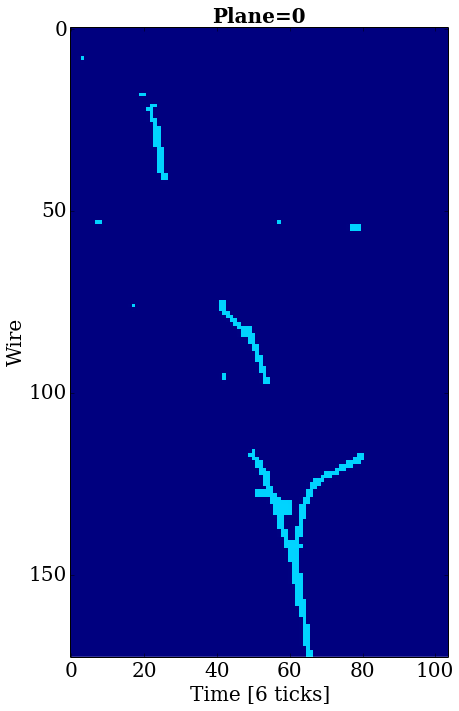

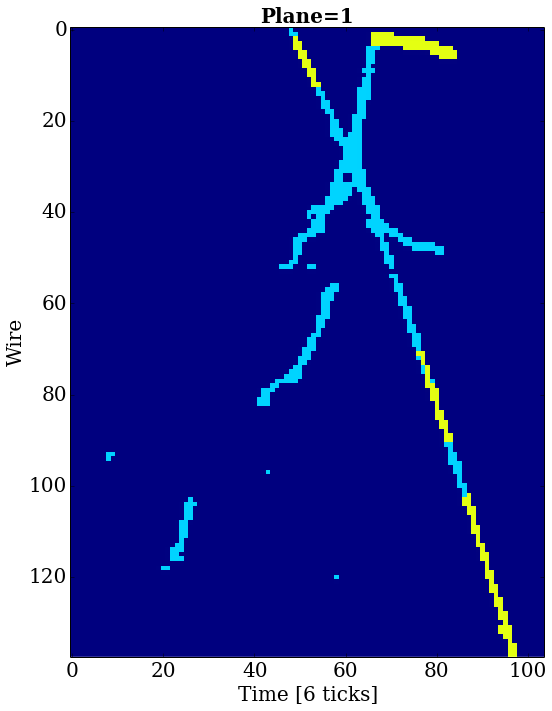

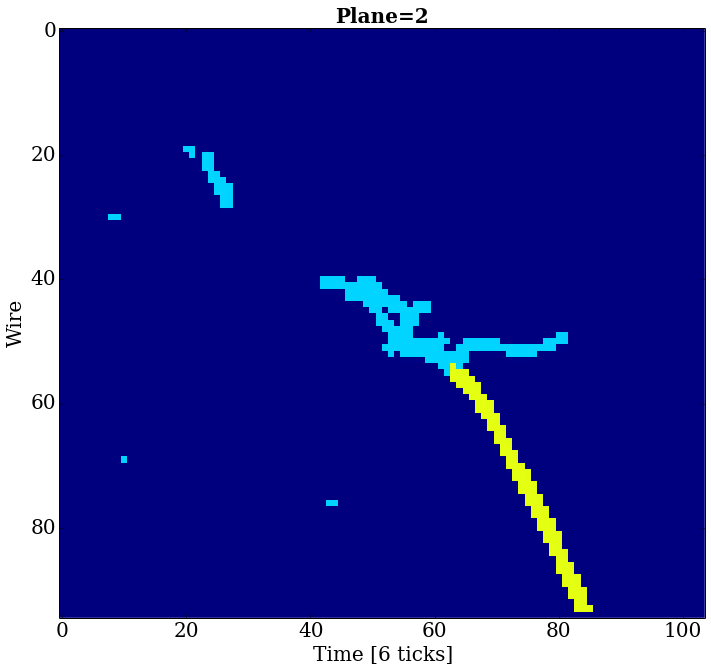

In [6]:
for plane in xrange(len(track_img_v)):
    shower_img  = np.where(shower_img_v[plane] >10.0,85.0 ,0.0).astype(np.uint8)# Threshold shower image
    track_img   = np.where(track_img_v[plane]  >10.0,160.0,0.0).astype(np.uint8)# Threshold track  image
    fig,ax = plt.subplots(figsize=(10,10))
    img  = shower_img  + track_img
    ax.set_xlabel('Time [6 ticks]',fontsize=20)
    ax.set_ylabel('Wire',fontsize=20)
    ax.imshow(img,cmap='jet',interpolation='none',vmin=0.,vmax=255.)# Plot track&shower image in 'jet' colormap
    ax.tick_params(labelsize=20)
    ax.set_title("Plane=%d"%plane,fontsize=20,fontweight='bold')
    plt.tight_layout()
    plt.show()

### LArOpenCV AlgoModule data printout
Now, per algorithm in the chain, we will go one by one and printout the data that exists in AlgoData

### Track Vertex Seeds
On track image, find the Defect point and PCA crossing point locations, they will be marked with a yellow star

Algorithm ID: 1
====> Start Plane 0


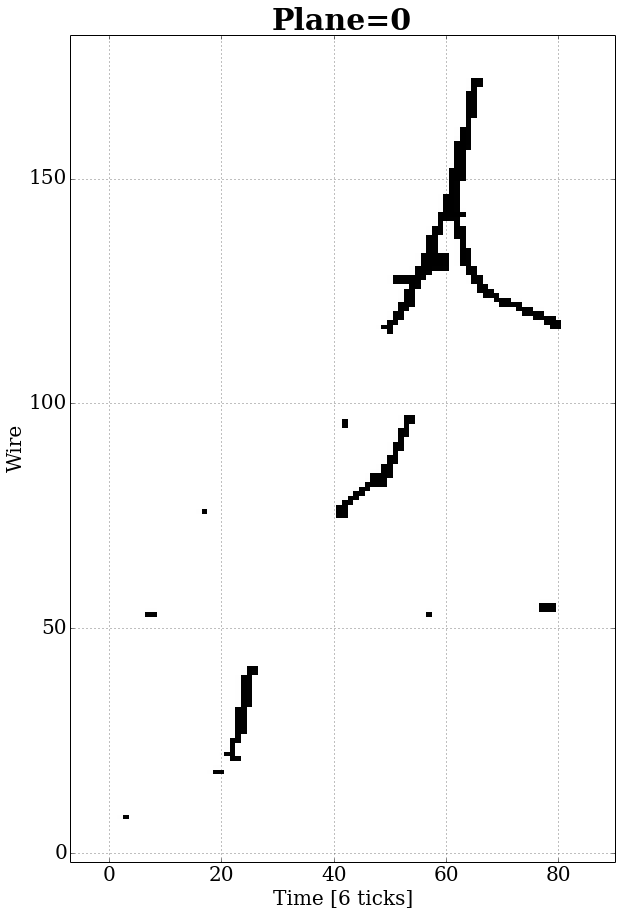

====> End Plane 0
====> Start Plane 1


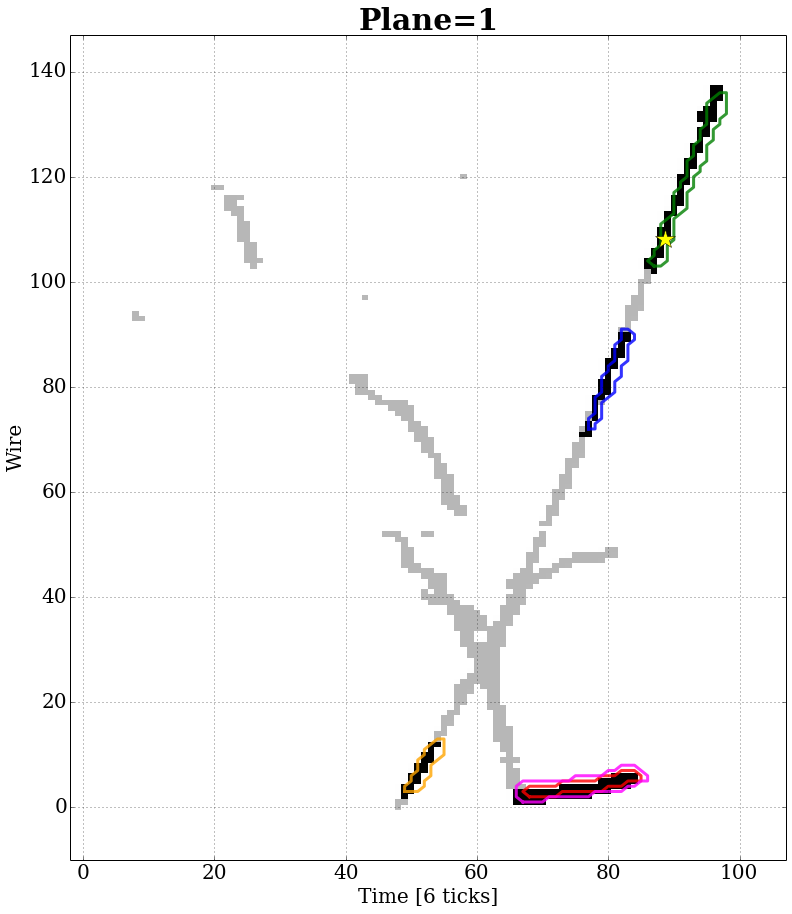

====> End Plane 1
====> Start Plane 2


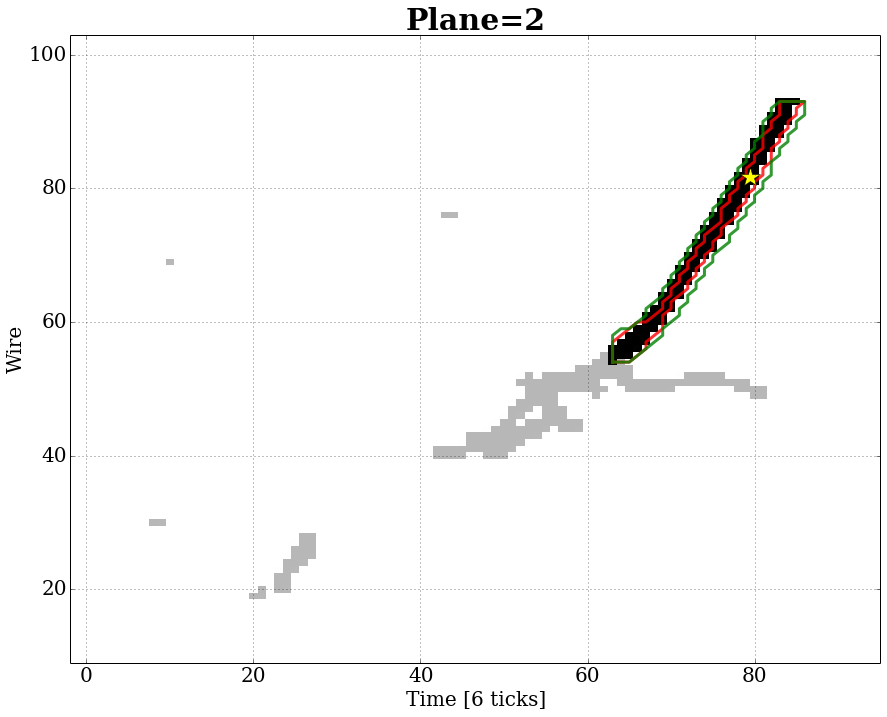

====> End Plane 2


In [7]:
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10
mgr = larbysimg.Manager()# LArbysImage Manager Pointer
dm  = mgr.DataManager() # LArOpenCV Data Manager
algoid = dm.ID("trackvertexseeds")# Function to return the Algorithm ID 
print "Algorithm ID:",algoid
for plane in xrange(3):
    # =>Draw track and shower images
    print "====> Start Plane",plane
    fig,ax=plt.subplots(figsize=(12,12),facecolor='w')
    shape_img1 = track_img_v[plane]
    shape_img2 = shower_img_v[plane]
    shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
    shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
    shape_img=shape_img1+shape_img2
    ax.imshow(shape_img,cmap='Greys',interpolation='none')
    nz_pixels=np.where(shape_img>0.0)
    
    ix=0
        
    vertex_seeds_v = dm.Data(algoid,plane).as_vector() # Retrieve Vertex Seeds data
    cluscomp_v     = dm.Data(algoid,3+plane).as_vector() # Retrieve ClusterCompound data. First Three are containers for 
                                                    # vertex_seeds on 3 planes

    # =>Draw contours
    # Loop over ClusterCompound data
    for cluscomp_id in xrange(cluscomp_v.size()):
        cluscomp = cluscomp_v[cluscomp_id]
        # Loop over atomic contour
        for atomic_id in xrange(cluscomp.size()):
            atomic = cluscomp[atomic_id]
            # Get all points in a contour
            pts=[[atomic[p_id].x,atomic[p_id].y] for p_id in xrange(atomic.size())]
            if len(pts)==0: continue
            pts.append(pts[0])
            pts=np.array(pts)
            # Draw contours
            plt.plot(pts[:,0],pts[:,1],'-',lw=3,color=colors[ix],alpha = 0.8)
            ix+=1
    
    # =>Draw Seeds
    pts_v = np.array([[vertex_seeds_v[i].x,
                       vertex_seeds_v[i].y] for i in xrange(vertex_seeds_v.size())])
    if pts_v.size>0:
        plt.plot(pts_v[:,0],pts_v[:,1],'*',markersize=20,color='yellow')

    plt.tight_layout()

    try:
        ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
        ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
    except ValueError:
        pass

    plt.xlabel('Time [6 ticks]',fontsize=20)
    plt.ylabel('Wire',fontsize=20)
    plt.tick_params(labelsize=20)
    ax.set_aspect(0.8)
    ax.grid()
    ax.set_title("Plane=%d"%plane,fontsize=30,fontweight='bold')
    plt.show()
    print "====> End Plane",plane

### Track Vertex Estimate
Use the circle scanning procedure to estimate a 3D location where vertex might exists, marked by the cyan star. The track contours are show on the image as well

Algorithm ID: 2
There are ' 0 ' Track Vertex 


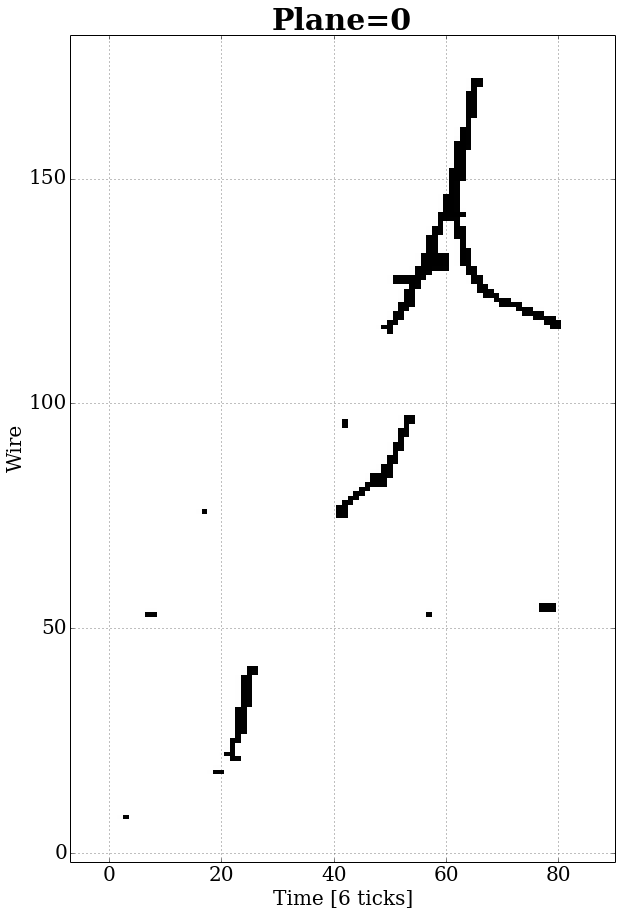

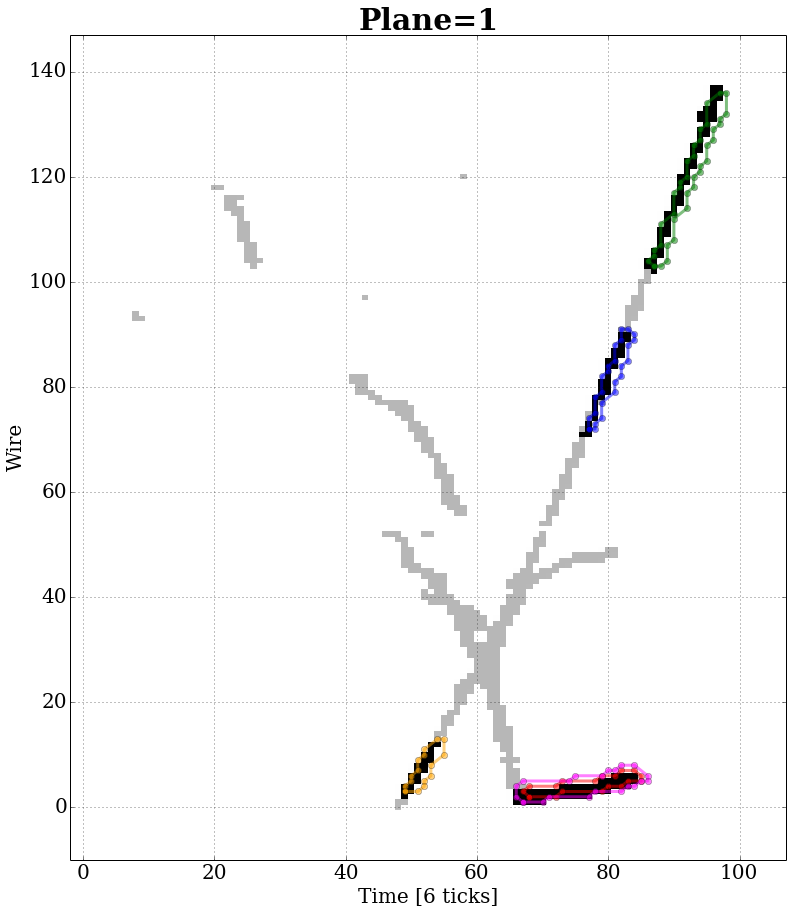

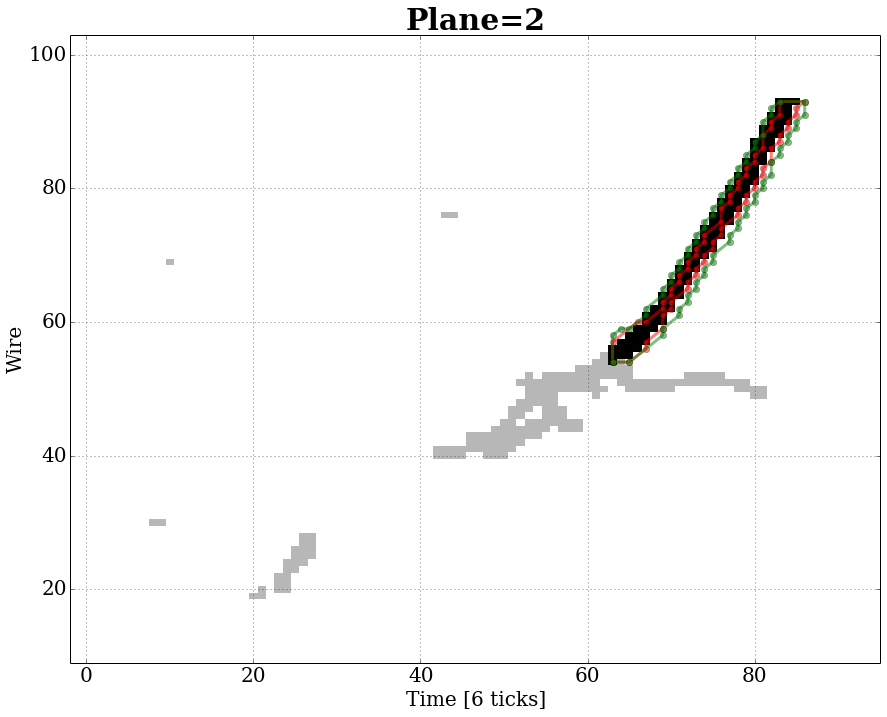

In [8]:
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10
dm=mgr.DataManager() # LArbysImage Manager Pointer
algoid=dm.ID("trackvertexestimate") # Get the algorithm ID
print "Algorithm ID:",algoid
vertex_vv = dm.Data(algoid,0).as_vector()
print "There are '", vertex_vv.size(),"' Track Vertex "
for plane in xrange(3):
    # => Draw Shower and Track pictures
    fig,ax=plt.subplots(figsize=(12,12),facecolor='w')
    shape_img1 = track_img_v[plane]
    shape_img2 = shower_img_v[plane]
    shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
    shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
    shape_img=shape_img1+shape_img2
    ax.imshow(shape_img,cmap='Greys',interpolation='none')
    nz_pixels=np.where(shape_img>0.0)
    
    # =>Draw Contours and estimated Vertex
    ix=0
    cluscomp_v = dm.Data(algoid-1,3+plane).as_vector()
    for cluscomp_id in xrange(cluscomp_v.size()):
        cluscomp = cluscomp_v[cluscomp_id]
        for atomic_id in xrange(cluscomp.size()):
            atomic = cluscomp[atomic_id]
            pts=[[atomic[p_id].x,atomic[p_id].y] for p_id in xrange(atomic.size())]
            if len(pts)==0: continue
            pts.append(pts[0])
            pts=np.array(pts)
            plt.plot(pts[:,0],pts[:,1],'-o',lw=3,color=colors[ix], alpha = 0.5)
            ix+=1
    # Get estimated vertes
    pts_v = np.array([[vertex_vv[i].cvtx2d_v[plane].center.x,
                       vertex_vv[i].cvtx2d_v[plane].center.y] for i in xrange(vertex_vv.size())])
    if pts_v.size>0:
        print "\t<=== Track Vertex Candidates @ ===>\n",pts_v
        ax.plot(pts_v[:,0],pts_v[:,1],'*',markersize=30,color='cyan')
    
    plt.tight_layout()
    try:
        ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
        ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
    except ValueError:
        pass

    plt.xlabel('Time [6 ticks]',fontsize=20)
    plt.ylabel('Wire',fontsize=20)
    plt.tick_params(labelsize=20)
    ax.set_aspect(0.8)
    ax.grid()
    ax.set_title("Plane=%d"%plane,fontsize=30,fontweight='bold')
    plt.show()

### AngularMetric
Angular metric via scan projected on wire and time axis

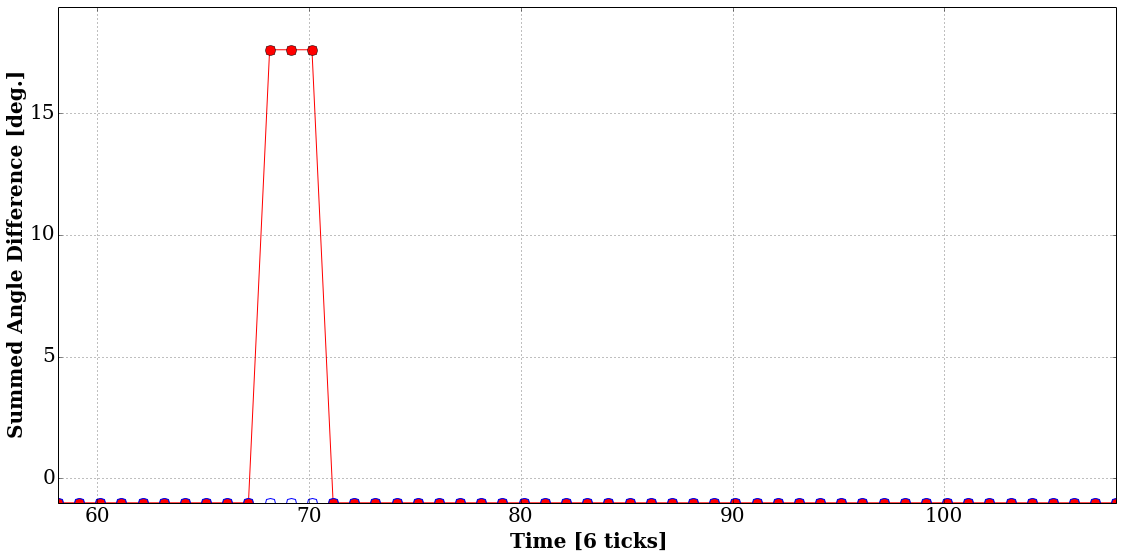

In [9]:
algoid=dm.ID("trackvertexestimate") # Get the Algorithm ID
alg=mgr.GetClusterAlg(algoid).Algo() # Get the "TrackVertexScan2D"(the class that does the angle Metric) Instance

tickscore0_y=[] # 0 refers to tick where at least two plane has One valid Δ(θ-Φ)
tickscore0_x=[] 

score0_v = alg.TimeBinnedScore0Mean()
for idx in xrange(score0_v.size()):
    v = score0_v[idx]
    tickscore0_y.append(v)
    tickscore0_x.append(idx*1 + alg.TimeBinMin())

tickscore1_y=[]# 1 refers to tick where at least two plane has Two valid Δ(θ-Φ)
tickscore1_x=[]

score1_v = alg.TimeBinnedScore1Mean()
for idx in xrange(score1_v.size()):
    v = score1_v[idx]
    tickscore1_y.append(v)
    tickscore1_x.append(idx*1 + alg.TimeBinMin())

tickscore0_x = np.array(tickscore0_x)
tickscore0_y = np.array(tickscore0_y)
tickscore1_x = np.array(tickscore1_x)
tickscore1_y = np.array(tickscore1_y)
ymin = tickscore0_y.min()
ymax = tickscore0_y.max()
if ymin > tickscore1_y.min(): ymin = tickscore1_y.min()
if ymax < tickscore1_y.max(): ymax = tickscore1_y.max()

fig,ax = plt.subplots(figsize=(16,8),facecolor='w')
ax.plot(tickscore0_x,tickscore0_y,marker='o',linestyle='-',color='red',markersize=10)
ax.plot(tickscore1_x,tickscore1_y,marker='o',linestyle='--',
         markeredgewidth=1,markeredgecolor='blue',markerfacecolor='None',markersize=10)


minimum_v  = alg.TimeBinnedScoreMinIndex()
minrange_v = alg.TimeBinnedScoreMinRange()
for idx in xrange(minimum_v.size()):
    xval = tickscore0_x[minimum_v[idx]]
    ax.plot([xval,xval],[0,360],marker='',linestyle='--',color='black',linewidth=2)
    xstart = tickscore0_x[minrange_v[idx].first]
    xend   = tickscore0_x[minrange_v[idx].second]
    ax.axvspan(xstart,xend, alpha=0.3, color='orange')

ax.set_xlabel('Time [6 ticks]',fontsize=20,fontweight='bold')
ax.set_ylabel('Summed Angle Difference [deg.]',fontsize=20,fontweight='bold')
ax.tick_params(labelsize=20)
plt.tight_layout()
ax.set_ylim(-1,ymax*1.1)
ax.set_xlim(tickscore0_x.min(),tickscore0_x.max())
ax.grid()
plt.show()


### TrackVertexScan
Estimate a 3D vertex by scanning 3D space by minimizing the angular metric.

In [10]:
dm=mgr.DataManager()# LArOpenCV Data Manager
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10

dm=mgr.DataManager()
algoid=dm.ID("trackvertexscan") # Retrive the module ID
print "Module ID is", algoid
data=dm.Data(algoid,0) # Retrive Vertex 3D data
vtx3d_v=data.as_vector()
print "There are '", vtx3d_v.size(), "' 3D vertices"

for vtxid,vtx in enumerate(vtx3d_v):
    print "<=============================================================================>"
    print "<===================Start combined vertex ",vtxid," ==========================>"
    for plane in xrange(3):
        fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
        # Plot track and shower image
        shape_img1 = track_img_v[plane]
        shape_img2 = shower_img_v[plane]
        shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
        shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
        shape_img=shape_img1+shape_img2
        ax.imshow(shape_img,cmap='Greys',interpolation='none')
        nz_pixels=np.where(shape_img>0.0)
        print "There are ' ",vtx.vtx2d_v.size()," ' 2D vertices"
        # Plot vertex 3D data
        ax.plot(vtx.vtx2d_v[plane].pt.x,vtx.vtx2d_v[plane].pt.y,'*',color='cyan',markersize=20,alpha = 1.0)
        ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
        ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        #ax.set_title("Vertex Type: %d"%vtx.type)
        ax.grid()
        plt.show()
    print "<=============================================================================>"
    print "<===================End combined vertex ",vtxid," ==========================>"



Module ID is 3
There are ' 0 ' 3D vertices


### ShowerPlaneSeeds
Find 2D edge points of clusters in the track image, display as colored circles.

Module ID is  4


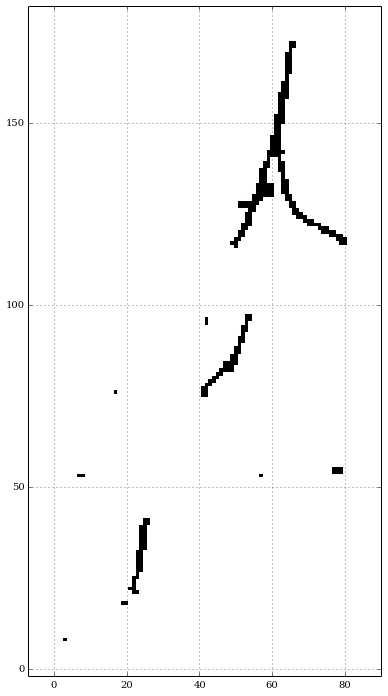

2D vertex postions ( 87.0 , 102.0 )
2D vertex postions ( 76.0 , 71.0 )
2D vertex postions ( 83.0 , 90.0 )
2D vertex postions ( 66.0 , 1.0 )


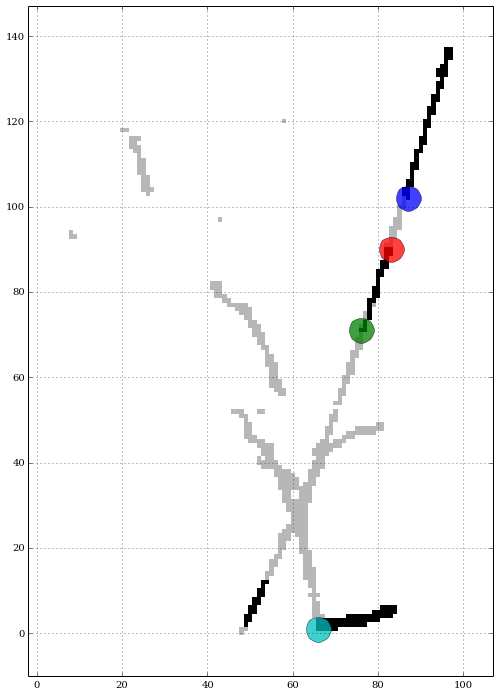

2D vertex postions ( 63.0 , 54.0 )


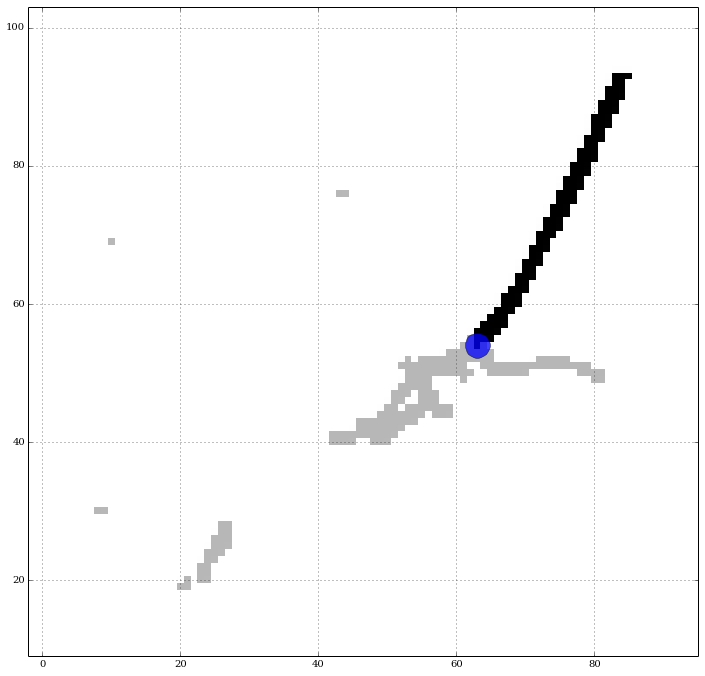

In [11]:
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10

dm=mgr.DataManager() # LArOpenCV data manager
algoid=dm.ID("showerplaneseeds") # Get the Algorithm ID
print "Module ID is ", algoid

for plane in xrange(3):
    vtxseed2d_v=dm.Data(algoid,plane).as_vector()# Get the ShowerPlane Seeds which are stored per plane
    # Plot Track and Shower images
    fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
    shape_img1 = track_img_v[plane]
    shape_img2 = shower_img_v[plane]
    shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
    shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
    shape_img=shape_img1+shape_img2
    ax.imshow(shape_img,cmap='Greys',interpolation='none')
    nz_pixels=np.where(shape_img>0.0)
    
    # Plost 2D vertex seeds
    for vtxseed2d in vtxseed2d_v:
        ax.plot(vtxseed2d.x,vtxseed2d.y,'o',markersize=25,alpha=0.75)
        print "2D vertex postions","(",vtxseed2d.x,",",vtxseed2d.y,")"

    ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
    ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)

    ax.grid()
    plt.show()


### ShowerVertexScan
Scan the 3D region around 2D edge points from last step(ShowerVertexSeeds), find 3D vertex

There are ' 1 ' 3D shower vertex after ShowerVertexScan
<=============================================================================>
<===================Start vertex  0  ==========================>
3


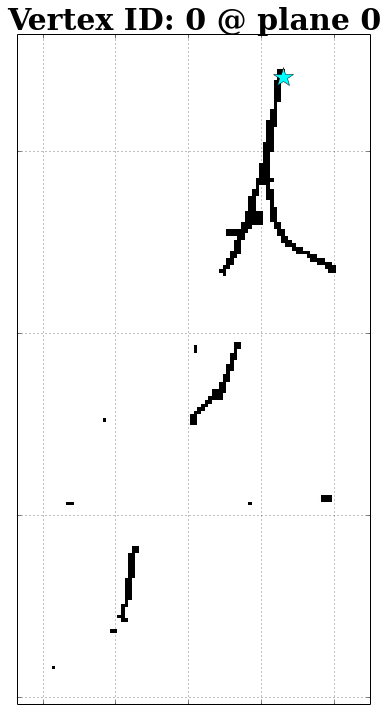

3


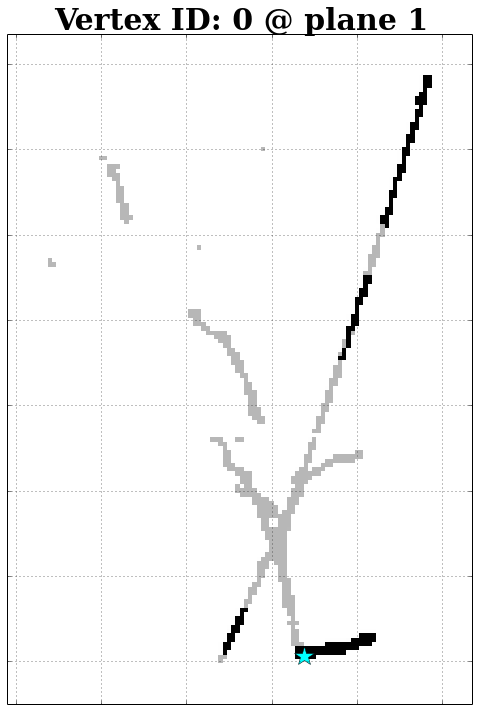

3


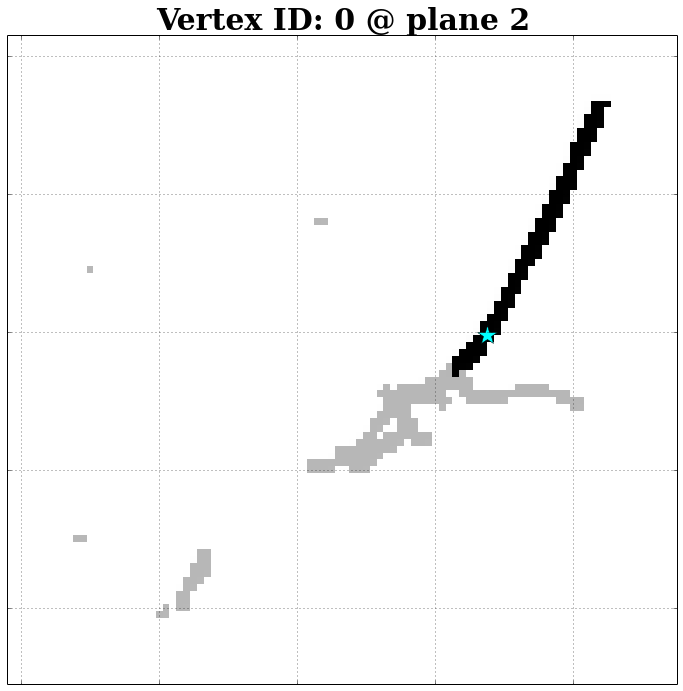

<=============================================================================>
<===================End vertex  0  ==========================>


In [12]:
dm=mgr.DataManager()
colors=['red','green','blue','orange','magenta','cyan','pink']
colors*=10

dm=mgr.DataManager()
algoid=dm.ID("showervertexscan")
vtxseed3d_v=dm.Data(algoid,0).as_vector()# Get 3D ShowerVertexScan data
print "There are '", vtxseed3d_v.size(),"' 3D shower vertex after ShowerVertexScan"

for vtxid,vtx in enumerate(vtxseed3d_v):
    print "<=============================================================================>"
    print "<===================Start vertex ",vtxid," ==========================>"
    for plane in xrange(3):
        # Plot Track and Shower images
        fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
        shape_img1 = track_img_v[plane]
        shape_img2 = shower_img_v[plane]
        shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
        shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
        shape_img=shape_img1+shape_img2
        ax.imshow(shape_img,cmap='Greys',interpolation='none')
        nz_pixels=np.where(shape_img>0.0)
        print vtx.vtx2d_v.size()
        
        # Plot Vertices from ShowerVertexscan
        ax.plot(vtx.vtx2d_v[plane].pt.x,vtx.vtx2d_v[plane].pt.y,'*',color='cyan',markersize=20)
        
        ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
        ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("Vertex ID: %d @ plane %d"%(vtxid,plane),fontsize=30,fontweight='bold')
        ax.grid()
        plt.show()
    print "<=============================================================================>"
    print "<===================End vertex ",vtxid," ==========================>"



### Combined Vertices
Consolidate wire/time/shower vertices and their ParticleClusters into one AlgoModule

There are ' 1 ' 3D vertices
<=============================================================================>
<===================Start combined vertex  0  ==========================>
Par data sz @ plane 0 is 0
Par data sz @ plane 1 is 2


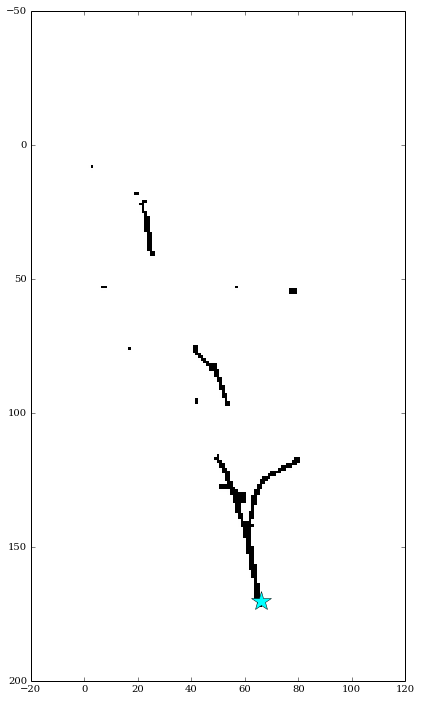

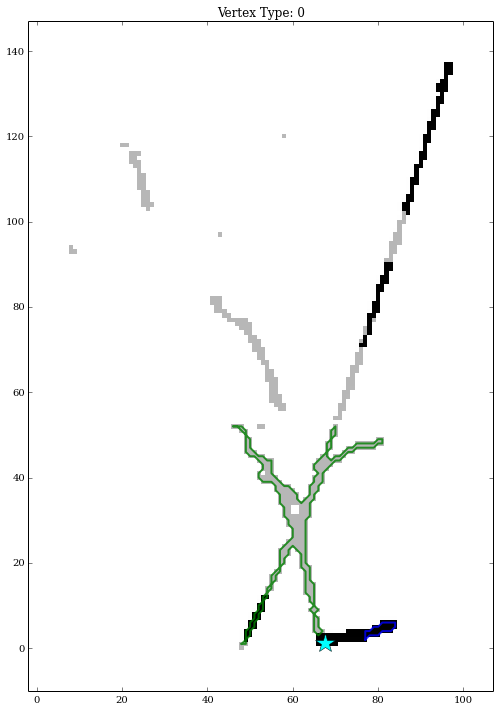

Par data sz @ plane 2 is 5


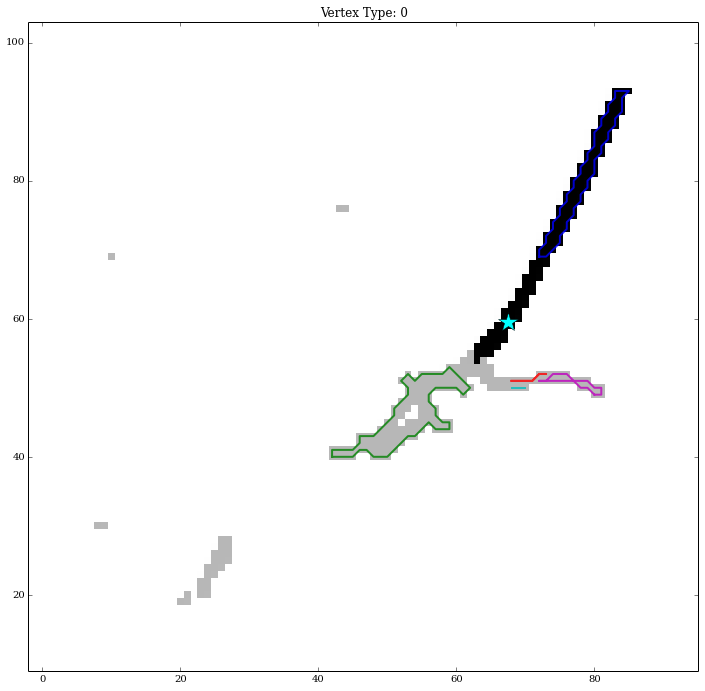

<=============================================================================>
<===================End combined vertex  0  ==========================>


In [13]:
algoid=dm.ID("combinedvertexanalysis")
vtx_data=dm.Data(algoid,0).as_vector()# Get the 3D Vertex data from CombinedVertexAnalysis
print "There are '", vtx_data.size(),"' 3D vertices"
assman=dm.AssManager() # Get the Association Manager which returns the asscioations of vertex and particles
for vtxid,vtx in enumerate(vtx_data):
    print "<=============================================================================>"
    print "<===================Start combined vertex ",vtxid," ==========================>"
    for plane in xrange(3):
        # Plot Shower and Track pixels
        fig,ax = plt.subplots(figsize=(12,12),facecolor='w')
        shape_img1 = track_img_v[plane]
        shape_img2 = shower_img_v[plane]
        shape_img1=np.where(shape_img1>10.0,255.0,0.0).astype(np.uint8)
        shape_img2=np.where(shape_img2>10.0,100.0,0.0).astype(np.uint8)
        shape_img=shape_img1+shape_img2
        ax.imshow(shape_img,cmap='Greys',interpolation='none')
        nz_pixels=np.where(shape_img>0.0)
        
        # Plot 2D vertices
        ax.plot(vtx.vtx2d_v[plane].pt.x,
                vtx.vtx2d_v[plane].pt.y,
                '*',color='cyan',markersize=20)
        
        par_data=dm.Data(algoid,plane+1)
        print "Par data sz @ plane",plane,"is",par_data.as_vector().size()
        ass_t = np.array(assman.GetManyAss(vtx,par_data.ID())) # Get the associations of this vertex and the particles
        if ass_t.size==0:
            continue

        # Plot the contour of the 2 assocaited particles
        par_data_v=par_data.as_vector()
        for id_ in ass_t:
            ctor=[[pt.x,pt.y] for pt in par_data_v[id_]._ctor]
            if len(ctor)==0: continue
            ctor.append(ctor[0])
            ctor=np.array(ctor)
            ax.plot(ctor[:,0],ctor[:,1],'-',lw=2,alpha=0.8)


        ax.set_ylim(np.min(nz_pixels[0])-10,np.max(nz_pixels[0])+10)
        ax.set_xlim(np.min(nz_pixels[1])-10,np.max(nz_pixels[1])+10)
        ax.set_title("Vertex Type: %d"%vtx.type)
        plt.show()
    print "<=============================================================================>"
    print "<===================End combined vertex ",vtxid," ==========================>"

